# Import

In [1]:
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory

# Data importeren

Importeren van de data uit drive,
vul de authorization code in die verkregen wordt via de link of er wordt al direct een scherm opgebracht waar je kan inloggen.

In [11]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/Schilderijen-Classificeren_Arthur-Huys/datasets" "/content/datasets"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
ln: failed to create symbolic link '/content/datasets/datasets': File exists


In [12]:
import shutil
shutil.unpack_archive('datasets/Picasso_Rubens_VanGogh_Mondriaan_rembrandt_1000_20_20.zip','.','zip')

# creëren datasets

Bij het creëren van deze datasets moet de class_mode verandert naar categorical omdat we nu met multi class data werken (3 verschillende labels).

In [13]:
train_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_Mondriaan_rembrandt_1000_20_20/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

validation_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_Mondriaan_rembrandt_1000_20_20/validation",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

test_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_Mondriaan_rembrandt_1000_20_20/test",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

Found 5000 files belonging to 5 classes.
Found 100 files belonging to 5 classes.
Found 100 files belonging to 5 classes.


# Building model

In [14]:
base_model = keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet",
    classes=5,
    classifier_activation="softmax")

base_model.trainable = True
for layer in base_model.layers[:-12]:
  layer.trainable = False

In [15]:
data_augmentation = keras.Sequential(
    [layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
     layers.RandomContrast(0.5,1.5)])

In [16]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [17]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

# Training model

In [18]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [19]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
157/157 [==============================] - ETA: 0s - loss: 0.5366 - accuracy: 0.8462

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


157/157 [==============================] - 65s 306ms/step - loss: 0.5366 - accuracy: 0.8462 - val_loss: 0.2574 - val_accuracy: 0.9200
Epoch 2/30
157/157 [==============================] - 46s 283ms/step - loss: 0.1773 - accuracy: 0.9378 - val_loss: 0.3212 - val_accuracy: 0.9300
Epoch 3/30
157/157 [==============================] - 46s 283ms/step - loss: 0.1161 - accuracy: 0.9604 - val_loss: 0.3450 - val_accuracy: 0.9000
Epoch 4/30
157/157 [==============================] - 47s 288ms/step - loss: 0.0995 - accuracy: 0.9674 - val_loss: 0.2393 - val_accuracy: 0.9400
Epoch 5/30
157/157 [==============================] - 46s 286ms/step - loss: 0.0724 - accuracy: 0.9758 - val_loss: 0.1656 - val_accuracy: 0.9400
Epoch 6/30
157/157 [==============================] - 46s 286ms/step - loss: 0.0600 - accuracy: 0.9808 - val_loss: 0.1611 - val_accuracy: 0.9400
Epoch 7/30
157/157 [==============================] - 46s 281ms/step - loss: 0.0506 - accuracy: 0.9820 - val_loss: 0.1761 - val_accuracy: 0.9

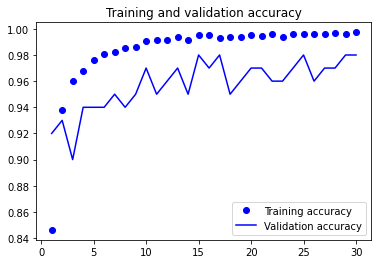

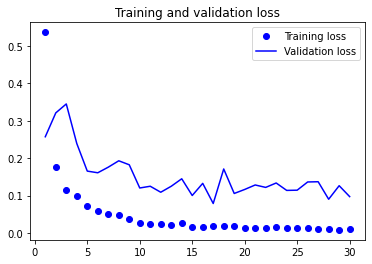

In [20]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Testing

Hier kunnen we weer zien dat de validation accuracy ongeveer gelijk blijf na de 40ste epoch.

In [21]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

4/4 [==============================] - 2s 170ms/step - loss: 0.1064 - accuracy: 0.9600
Test accuracy: 0.960


In [23]:
test_model.save("model_five_painters.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [25]:
!ln -s "/gdrive/My Drive/Schilderijen-Classificeren_Arthur-Huys/models" "/content/models"